# `pspd` in the wild

## Input data

First, let's load and visualize the point cloud that contains the points on the surface.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

In [2]:
%config InlineBackend.figure_format='retina'

In [3]:
dir = os.path.join('playground', 'input', 'data')
fname = os.path.join(dir, 'head.scaled')  # in centimeters
points = np.loadtxt(fname + '.xyz')

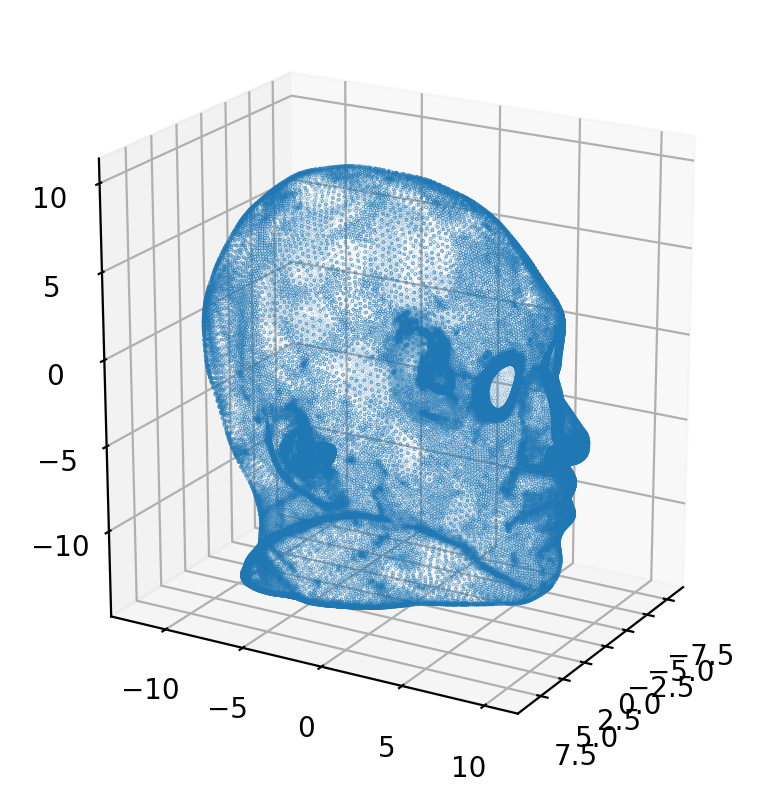

In [4]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(*points.T, s=0.05)
ax.set_box_aspect(np.ptp(points, axis=0))
ax.view_init(20, 30)
plt.show()

Now, let's generate the power density in a Gaussian pattern over the entire surface with the "hot spot" located on the upper crus of the right outer ear.

The function has already been defined in the `single_source` Python file in the `playground` directory. It requires the following parameters:
* *amplitude* of the incident power density at the centre of the irradiated region in watts per squared meter,
* *radius* of a circular area representing the irradiated region (unit should correspond the unit of the point cloud, in this case, it should be given in centimeters),
* *center point* of the irradiated region (again, the unit should correspond the unit of the point cloud, in this case, it should be given in centimeters), and
* *scaler* that stretches the Euclidean distance between the centre point and remaining points of the irradiated region component-wise (dimensionless quantity).

In [5]:
from playground.single_source import generate_power_density

In [6]:
power_density = generate_power_density(
    amplitude=10,  # W/m2
    radius=2.5,  # cm
    query_point=np.array([8.4082, -3.0716, -1.8224]),  # cm
    points=points,  # cm
    scaler=[1, 0.5, 0.25]
)

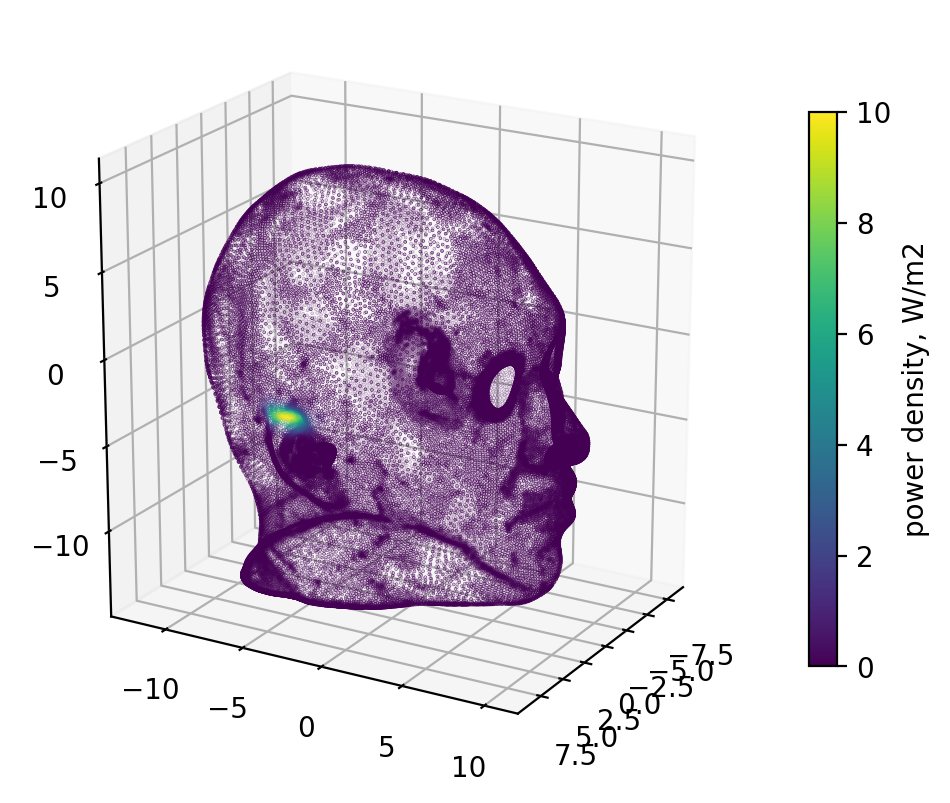

In [7]:
fig = plt.figure()
ax = plt.axes(projection='3d')
s = ax.scatter(*points.T, s=0.05, c=power_density)
cbar = fig.colorbar(s, ax=ax, shrink=0.75, label='power density, W/m2')
ax.set_box_aspect(np.ptp(points, axis=0))
ax.view_init(20, 30)
plt.show()

## Detection of the peak spatial-average power density

### Point cloud

In the simplest implementation, the algorithm requires only a 3-dimensional point cloud sampled on the surface of the model along with the corresponding power density values at each point. Additionally, the area of the square projection of the evaluation surface has to be defined in order to find the peak spatially averaged power density on the surface. In practice, this area should either be 4 or 1 squared centimeter, depending on the frequency at hand (for details see the recent [ICNIRP's RF EMF Guidelines](https://www.icnirp.org/cms/upload/publications/ICNIRPrfgdl2020.pdf) and [IEEE standard for safety levels with respect to human exposure to electric, magnetic, and electromagnetic fields from 0 Hz to 300 GHz](https://ieeexplore.ieee.org/document/8859679)). However, user is free to define any value for the area of the square projection.

In [8]:
from pspd import PSPD

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [9]:
pspd = PSPD(points, power_density)
pspd.find(projected_area=4)

INFO:root:Unrecognized mesh; proceeding without it...
INFO:root:Estimating normals with k-nn = 22...
INFO:root:Execution started at 2023-08-02 20:20:44.554579
INFO:root:Execution finished at 2023-08-02 20:21:00.711452
INFO:root:Elapsed time: 16.1565 s
INFO:root:Execution started at 2023-08-02 20:21:00.727163


  0%|          | 0/63333 [00:00<?, ?it/s]

INFO:root:Execution finished at 2023-08-02 20:22:36.729959
INFO:root:Elapsed time: 96.0023 s


Since no mesh has been provided, in order to evaluate the surface integrals on conformal surfaces, which corresponds to the projected averaging area mapped on the surface of the human head model, surface normals are automatically estimated.

This way, the area of the evaluation surface is approximated as the surface integral of normals' magnitude.

The results can be extracted in dictionary. From there, it is straightforward to check the peak spatial-average power density.

Note, the current implementation estimates the spatially averaged power density by integrating the Poynting vector on the surface. The implentation of the defintion for the surface-normal propagation-direction power density into the evaluation surface is directly taken from the [IEC/IEEE 63195 standard](https://webstore.iec.ch/publication/62754).

In [10]:
res = pspd.get_results()
res['spatially averaged power density']

4.67646452743277

Now, let's visualize the square patch in relation to the point cloud.

In [11]:
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d.art3d import pathpatch_2d_to_3d

In [12]:
# extract relevant data from the output
p = res['query point']
nbh = res['k-neighbourhood']
area = res['surface area']

# compute the angle of rotation for matplotlib's square patch
idx_at_ymin = np.argmin(nbh[:, 1])
ymin = nbh[idx_at_ymin, 1]
z_at_ymin = nbh[idx_at_ymin, 2]

idx_at_zmin = np.argmin(nbh[:, 2])
zmin = nbh[idx_at_zmin, 2]
y_at_zmin = nbh[idx_at_zmin, 1]

d = z_at_ymin - zmin
r = np.sqrt(np.sqrt(area))
angle_rad = 2 * np.arcsin(d / (2 * r))
angle = np.rad2deg(angle_rad)

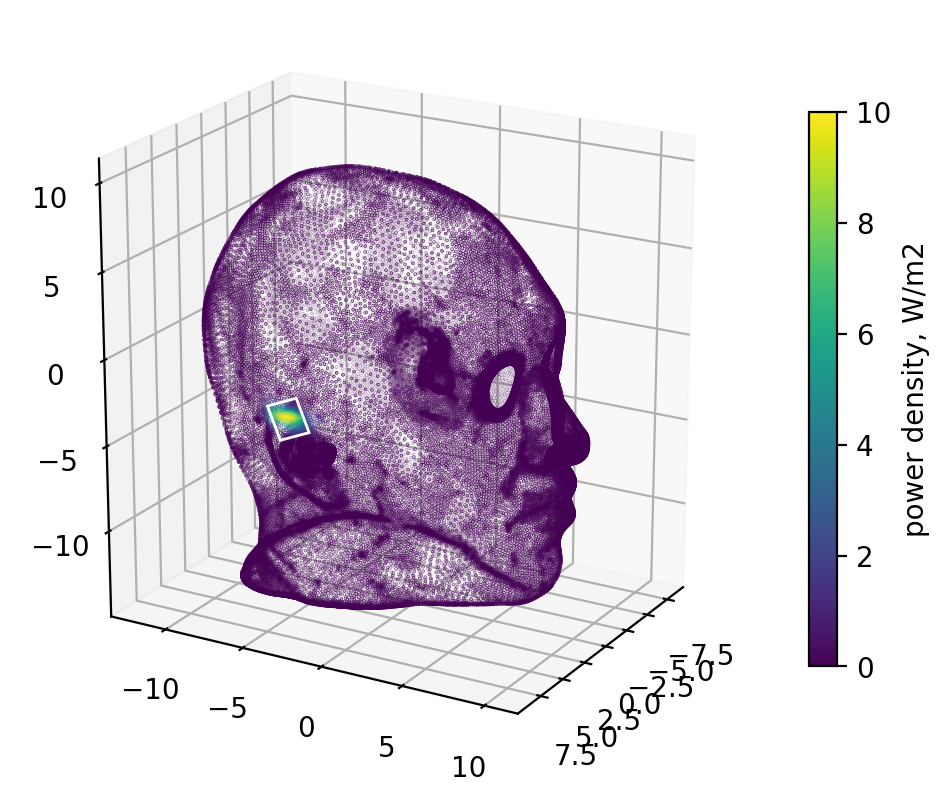

In [13]:
fig = plt.figure()
ax = plt.axes(projection='3d')
s = ax.scatter(*points.T, s=0.05, c=power_density)
cbar = fig.colorbar(s, ax=ax, shrink=0.75, label='power density, W/m2')
square = Rectangle(xy=(ymin, z_at_ymin),
                   width=np.sqrt(area),
                   height=np.sqrt(area),
                   angle=-angle,
                   ec='w', fc='none')
ax.add_patch(square)
pathpatch_2d_to_3d(square, z=p[0], zdir='x')
ax.set_box_aspect(np.ptp(points, axis=0))
ax.view_init(20, 30)
plt.show()

### Triangle mesh

If, however, the triangle mesh has been provided, the conformal surface, which again corresponds to the projected averaging area mapped on the surface of the human head model, is computed by adding area contributions of triangles as specified in the [IEC/IEEE 63195 standard](https://webstore.iec.ch/publication/62754).

In [14]:
from matplotlib.colors import LightSource
import open3d as o3d

In [15]:
normals = np.loadtxt(fname + '.normals')
mesh = o3d.io.read_triangle_mesh(fname + '.iso.watertight.off')
mesh_smp = mesh.simplify_quadric_decimation(6500)
vert_smp = np.asarray(mesh_smp.vertices)
tri_smp = np.asarray(mesh_smp.triangles)
ls = LightSource(40, 30)

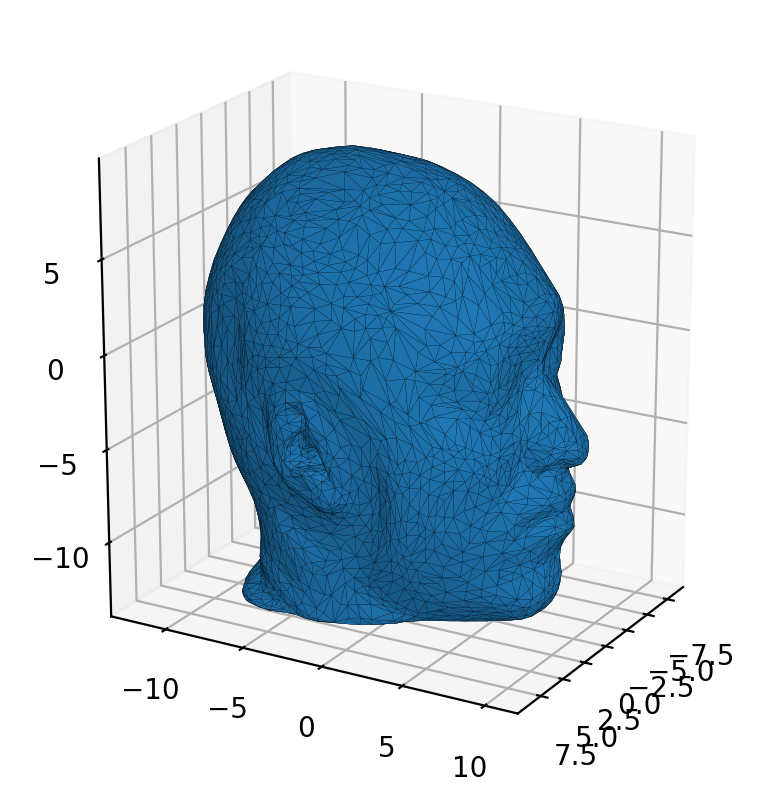

In [16]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_trisurf(*vert_smp.T,
                triangles=tri_smp,
                ec='k', lw=0.05,
                lightsource=ls)
ax.set_box_aspect(np.ptp(points, axis=0))
ax.view_init(20, 30)
plt.show()

In [17]:
pspd = PSPD(points, power_density, normals=normals, mesh=mesh)
pspd.find(projected_area=4)

INFO:root:Execution started at 2023-08-02 20:22:41.286205


  0%|          | 0/63333 [00:00<?, ?it/s]

INFO:root:Execution finished at 2023-08-02 20:26:31.702185
INFO:root:Elapsed time: 230.4148 s


In [18]:
res = pspd.get_results()
res['spatially averaged power density']

4.45096085777223

Now again, let's visualize the square patch in relation to the point cloud.

In [19]:
# extract relevant data from the output
p = res['query point']
nbh = res['k-neighbourhood']
area = res['surface area']

# compute the angle of rotation for matplotlib's square patch
idx_at_ymin = np.argmin(nbh[:, 1])
ymin = nbh[idx_at_ymin, 1]
z_at_ymin = nbh[idx_at_ymin, 2]

idx_at_zmin = np.argmin(nbh[:, 2])
zmin = nbh[idx_at_zmin, 2]
y_at_zmin = nbh[idx_at_zmin, 1]

d = z_at_ymin - zmin
r = np.sqrt(np.sqrt(area))
angle_rad = 2 * np.arcsin(d / (2 * r))
angle = np.rad2deg(angle_rad)

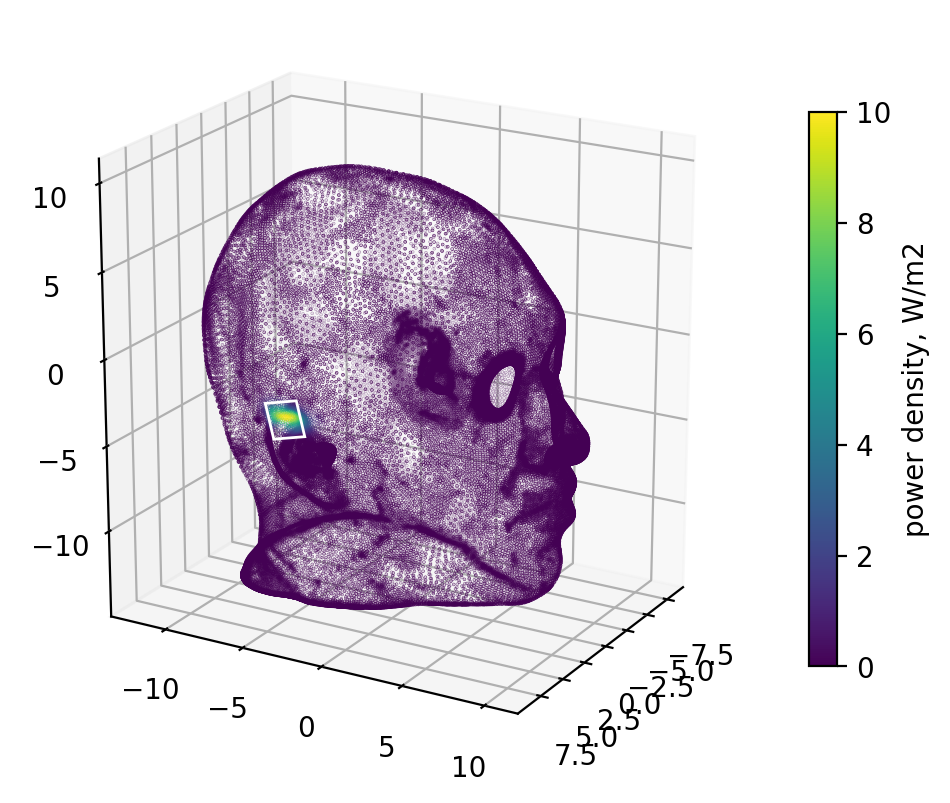

In [20]:
fig = plt.figure()
ax = plt.axes(projection='3d')
s = ax.scatter(*points.T, s=0.05, c=power_density)
cbar = fig.colorbar(s, ax=ax, shrink=0.75, label='power density, W/m2')
square = Rectangle(xy=(ymin, z_at_ymin),
                   width=np.sqrt(area),
                   height=np.sqrt(area),
                   angle=-angle,
                   ec='w', fc='none')
ax.add_patch(square)
pathpatch_2d_to_3d(square, z=p[0], zdir='x')
ax.set_box_aspect(np.ptp(points, axis=0))
ax.view_init(20, 30)
plt.show()

Even though the algorithm was able to find (more-or-less) the same averaging area, there is a substantial difference between the peak spatial-average power density. This is mainly attributable to the way the conformal averaging area (for spatial averaging) is computed. Namely, the surface area estimation via surface integration of normals' magnitude is highly imprecise and dependent on the spatial distribution of normals and the approximation power of the quadrature technique.

## Speedup

If the incidence of the electromagnetic field is known, the algorithm allows to identify points visible from the predefined direction, which should correspond to the propagation direction of the electromagnetic field.
This step is optional, but it allows to focus solely on a region that is in the line of sight of the sources.
Here, the so-called ["hidden point removal" operator](https://www.weizmann.ac.il/math/ronen/sites/math.ronen/files/uploads/katz_tal_basri_-_direct_visibility_of_point_sets.pdf) or HPR for short, which determines the visible points in a point cloud, as viewed from any given viewpoint is employed.

In [21]:
# define the point-of-view
pov = np.mean(points, axis=0)
diameter = np.linalg.norm(points.ptp(axis=0))
pov[0] += 1.5 * diameter
pov[1] += 0.5 * diameter

In [22]:
pspd = PSPD(points, power_density, normals=normals, mesh=mesh)
pspd.find(projected_area=4,
          pov=pov,  # viewpoint
          p=np.pi,  # controls the radius for the HPR spherical transformation
         )

INFO:root:Execution started at 2023-08-02 20:26:33.008394


  0%|          | 0/24810 [00:00<?, ?it/s]

INFO:root:Execution finished at 2023-08-02 20:27:58.098174
INFO:root:Elapsed time: 85.0892 s


In [23]:
visible, _ = pspd.get_points()
points.shape[0], visible.shape[0]

(63333, 24810)

The search space is reduced from 63,333 point to 24,810 points, which resulted in almost a threefold speedup with respect to execution time.

In [24]:
res = pspd.get_results()
res['spatially averaged power density']

4.45096085777223

In [25]:
# compute the angle of rotation for matplotlib's square patch
idx_at_ymin = np.argmin(nbh[:, 1])
ymin = nbh[idx_at_ymin, 1]
z_at_ymin = nbh[idx_at_ymin, 2]

idx_at_zmin = np.argmin(nbh[:, 2])
zmin = nbh[idx_at_zmin, 2]
y_at_zmin = nbh[idx_at_zmin, 1]

d = z_at_ymin - zmin
r = np.sqrt(np.sqrt(area))
angle_rad = 2 * np.arcsin(d / (2 * r))
angle = np.rad2deg(angle_rad)

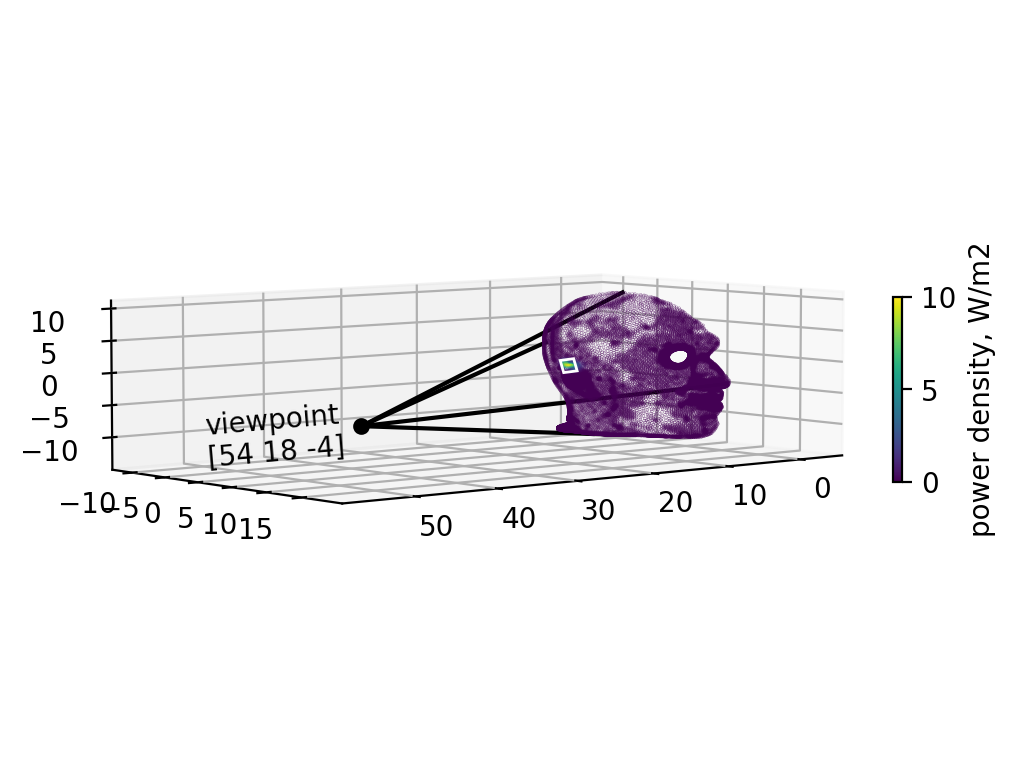

In [28]:
fig = plt.figure()
ax = plt.axes(projection='3d')
s = ax.scatter(*points[visible].T, s=0.015, c=power_density[visible])
cbar = fig.colorbar(s, ax=ax, shrink=0.25, label='power density, W/m2')
square = Rectangle(xy=(ymin, z_at_ymin),
                   width=np.sqrt(area),
                   height=np.sqrt(area),
                   angle=-angle,
                   ec='w', fc='none')
ax.add_patch(square)
pathpatch_2d_to_3d(square, z=p[0], zdir='x')
ax.plot(*np.c_[pov, points[visible][points[visible, 1].argmin()]], 'k-')
ax.plot(*np.c_[pov, points[visible][points[visible, 1].argmax()]], 'k-')
ax.plot(*np.c_[pov, points[visible][points[visible, 2].argmin()]], 'k-')
ax.plot(*np.c_[pov, points[visible][points[visible, 2].argmax()]], 'k-')
ax.plot(*pov, 'ko', ms=5)
ax.text(*pov*1.45, s=f'viewpoint\n{pov.astype(int)}', zdir='x')
ax.set_box_aspect(np.ptp(points, axis=0)+pov)
ax.view_init(5, 50)
plt.show()